In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

import hssm
from hssm.distribution_utils.onnx.onnx import make_jax_logp_funcs_from_onnx
from hssm.utils import download_hf
from hssm.rl_utils import *

import pymc as pm

import pytensor.tensor as pt
#import pytensor
# from pytensor import function
# from pytensor.graph import Apply, Op

import jax
import jax.numpy as jnp
from jax import jit, lax, vmap
from jax.scipy.special import logsumexp
from jax.debug import print as jprint

import matplotlib.ticker as ticker
from scipy.stats import spearmanr

/users/kbera1/.conda/envs/RLDM_tutorial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and pre-process

In [2]:
savefile = np.load("./RLDM_tutorial/demo_data.npy", allow_pickle=True).item()

In [3]:
dataset = savefile['data']
# dataset = dataset[dataset['participant_id'] == 1]
# dataset['participant_id'] = 0
dataset

,participant_id,trial,response,rt,feedback,correct,q_val_0,q_val_1
0,0,0,0.0,0.935602,0.126686,0.0,0.234214,0.500000
1,0,1,0.0,1.114379,0.173100,0.0,0.190703,0.500000
2,0,2,0.0,0.564311,0.444935,0.0,0.371707,0.500000
3,0,3,0.0,2.885860,0.307207,0.0,0.325785,0.500000
4,0,4,0.0,0.532113,0.177911,0.0,0.220504,0.500000
...,...,...,...,...,...,...,...,...
195,19,195,0.0,0.966162,0.338367,0.0,0.325114,0.756108
196,19,196,0.0,0.895475,0.068675,0.0,0.151209,0.756108
197,19,197,1.0,1.320449,0.916207,1.0,0.151209,0.864679
198,19,198,1.0,1.392622,0.550503,1.0,0.151209,0.651619


In [4]:
jax_LAN_logp = make_jax_logp_funcs_from_onnx(
    "./RLDM_tutorial/angle.onnx", [True] * 5
)[0]

## JAX likelihood definition; vectorization

In [5]:
def jax_call_LAN(LAN_matrix):
    net_input = jnp.array(LAN_matrix)
    LL = jax_LAN_logp(
        net_input[:, 5:7],
        net_input[:, 0],
        net_input[:, 1],
        net_input[:, 2],
        net_input[:, 3],
        net_input[:, 4],
    )

    return LL

In [6]:
def jax_LL_func(
    subj_index,
    data,
    rl_alpha,
    scaler,
    a, 
    z,
    t,
    theta,
    participant_id,
    trial,
    feedback,
):

    ntrials_subj = 200
    rt = data[:, 0]
    response = data[:, 1]

    subj = jnp.astype(subj_index, jnp.int32)

    subj_rl_alpha = jax.lax.dynamic_slice(rl_alpha, [subj * ntrials_subj], [ntrials_subj])
    subj_scaler = jax.lax.dynamic_slice(scaler, [subj * ntrials_subj], [ntrials_subj])
    subj_a = jax.lax.dynamic_slice(a, [subj * ntrials_subj], [ntrials_subj])
    subj_z = jax.lax.dynamic_slice(z, [subj * ntrials_subj], [ntrials_subj])
    subj_t = jax.lax.dynamic_slice(t, [subj * ntrials_subj], [ntrials_subj])
    subj_theta = jax.lax.dynamic_slice(theta, [subj * ntrials_subj], [ntrials_subj])

    # subj_rl_alpha = rl_alpha[subj]
    # subj_scaler = scaler[subj]
    # subj_a = a[subj]
    # subj_z = z[subj]
    # subj_t = t[subj]
    # subj_theta = theta[subj]

    subj_trial = jax.lax.dynamic_slice(trial, [subj * ntrials_subj], [ntrials_subj])
    subj_response = jax.lax.dynamic_slice(response, [subj * ntrials_subj], [ntrials_subj])
    subj_rt = jax.lax.dynamic_slice(rt, [subj * ntrials_subj], [ntrials_subj])
    subj_feedback = jax.lax.dynamic_slice(feedback, [subj * ntrials_subj], [ntrials_subj])

    LAN_matrix_init = jnp.zeros((ntrials_subj, 7))
    q_val = jnp.ones(2) * 0.5

    def process_trial(carry, inputs):
        q_val, LL, LAN_matrix, t = carry
        state, action, rt, reward = inputs
        state = jnp.astype(state, jnp.int32)
        action = jnp.astype(action, jnp.int32)

        computed_v = (q_val[1] - q_val[0]) * subj_scaler[t]

        delta_RL = reward - q_val[action]
        q_val = q_val.at[action].set(q_val[action] + subj_rl_alpha[t] * delta_RL)

        LAN_matrix = LAN_matrix.at[t, :].set(
            jnp.array([computed_v, subj_a[t], subj_z[t], subj_t[t], subj_theta[t], rt, action])
        )

        return (q_val, LL, LAN_matrix, t + 1), None


    trials = (
        subj_trial,
        subj_response,
        subj_rt,
        subj_feedback,
    )
    (q_val, LL, LAN_matrix, _), _ = lax.scan(
        process_trial, (q_val, 0.0, LAN_matrix_init, 0), trials
    )
    ## BREAK POINT
    LL = jax_call_LAN(LAN_matrix)
    
    return LL

In [7]:
# Parallelize (vectorize) the likelihood computation across subjects. 'subj_index' arg to the JAX likelihood should be vectorized.
def vec_logp(*args):
    vmap = jax.vmap(
        jax_LL_func,
        # Only the first argument (subj), needs to be vectorized
        in_axes=(0, None, None, None, None, None, None, None, None, None, None),
    )
    #return jnp.sum(vmap(*args))
    res_LL = vmap(*args).ravel()

    res_LL = jnp.reshape(res_LL, (len(res_LL), 1))

    return res_LL


# Get jitted vectorized logp function.
jitted_vec_logp = jax.jit(vec_logp)

## Replicate HSSM functionality to build the pytensor op

In [8]:
# from functools import partial
# from ssms.basic_simulators.simulator import simulator
# from hssm.utils import decorate_atomic_simulator


def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):

    sim_rt = np.random.uniform(0.2, 0.6, n_samples)
    sim_ch = np.random.randint(0, 2, n_samples)

    return np.column_stack([sim_rt, sim_ch])


my_wrapped_simulator = partial(
    sim_wrapper, simulator_fun=simulator, model="custom", n_samples=1
)

decorated_simulator = decorate_atomic_simulator(
    model_name="custom", choices=[0, 1, 2], obs_dim=2
)(my_wrapped_simulator)

In [9]:
list_params = ['rl_alpha', 'scaler', 'a', 'z', 't', 'theta']

In [10]:
participant_id = dataset["participant_id"].values
trial = dataset["trial"].values
response = dataset["response"].values
feedback = dataset["feedback"].values
rt = dataset["rt"].values

num_subj = len(np.unique(dataset["participant_id"].values))
ntrials = num_subj * 200

rl_alpha = np.ones(ntrials) * 0.60
scaler = np.ones(ntrials) * 3.2
a = np.ones(ntrials) * 1.2
z = np.ones(ntrials) * 0.1
t = np.ones(ntrials) * 0.1
theta = np.ones(ntrials) * 0.1

In [11]:
from hssm.distribution_utils.dist import (
    #make_distribution,
    make_hssm_rv,
    make_likelihood_callable,
)

# Step 1: Define a pytensor RandomVariable
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=list_params
)

# Step 2: Define a likelihood function
logp_jax_op = make_likelihood_callable_TEST(
    loglik=jax_LL_func,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[True] * 10,
    params_only=None,
)

# Step 3: Define a distribution
CustomDistribution = make_distribution(
    #model_name="custom",
    #choices=[0, 1, 2],
    rv=CustomRV,
    loglik=logp_jax_op,
    list_params=list_params,
    bounds=dict(rl_alpha=(0.01, 1), scaler=(2, 5), a=(0.3, 2.5), z=(0.1, 0.9), t=(0.1, 2.0), theta=(0.0, 1.2)),
    extra_fields=[participant_id, trial, feedback]
)

inside approx_differentiable and jax
in_axes:  [0, None, None, None, None, None, None, None, None, None, None]


In [12]:
#subj = np.array([0])
subj = np.arange(20) #20

## Test and match the outputs from the jax function and the constructed pytensor op

In [13]:
jax_LL = jitted_vec_logp(subj,
    np.column_stack((rt, response)),
    rl_alpha,
    scaler,
    a, 
    z,
    t,
    theta,
    participant_id,
    trial,
    feedback,)
# np.sum(jax_LL)

In [14]:
np.sum(jax_LL)

Array(-6879.15262966, dtype=float64)

In [15]:
test_logp_out = logp_jax_op(
    subj,
    np.column_stack((rt, response)),
    rl_alpha,
    scaler,
    a, 
    z,
    t,
    theta,
    participant_id,
    trial,
    feedback,
)
LL = test_logp_out.eval()
print(np.sum(LL))

in Op:  False True [ 0  1  2 ... 17 18 19]
(4000, 11)
-6879.152629659229


# Pass the test distribution to PyMC

In [16]:
num_subj = 20 #20
num_trials_per_subj = 200
ntrials = num_subj * num_trials_per_subj

# Test via basic pymc model
with pm.Model() as model:

    # Group-level parameters
    group_rl_alpha_mean = pm.Uniform("group_rl_alpha_mean", lower=0.1, upper=1.0, initval=0.3)
    group_rl_alpha_sd = pm.Uniform("group_rl_alpha_sd", lower=0.0, upper=1.0)

    group_scaler_mean = pm.Uniform("group_scaler_mean", lower=1.0, upper=4.0, initval=1.5)
    group_scaler_sd = pm.Uniform("group_scaler_sd", lower=0.0, upper=1.0)

    group_a_mean = pm.Uniform("group_a_mean", lower=0.3, upper=2.5, initval=1.0)
    group_a_sd = pm.Uniform("group_a_sd", lower=0.0, upper=1.0)

    group_z_mean = pm.Uniform("group_z_mean", lower=0.10, upper=0.90, initval=0.2)
    group_z_sd = pm.Uniform("group_z_sd", lower=0.0, upper=1.0)

    group_t_mean = pm.Uniform("group_t_mean", lower=0.0, upper=2.0, initval=0.2)
    group_t_sd = pm.Uniform("group_t_sd", lower=0.0, upper=1.0)

    group_theta_mean = pm.Uniform("group_theta_mean", lower=0.0, upper=1.2, initval=0.3)
    group_theta_sd = pm.Uniform("group_theta_sd", lower=0.0, upper=1.0)

    # Non-centered parameterization using standard normal variables
    z_rl_alpha = pm.Normal("z_rl_alpha", mu=0, sigma=1, shape=num_subj)
    subj_rl_alpha = pm.Deterministic(
        "subj_rl_alpha",
        pm.math.clip(group_rl_alpha_mean + group_rl_alpha_sd * z_rl_alpha, 0.1, 1.0)
    )
    rl_alpha_det = pm.Deterministic("rl_alpha_det", pt.repeat(subj_rl_alpha, num_trials_per_subj))

    z_scaler = pm.Normal("z_scaler", mu=0, sigma=1, shape=num_subj)
    subj_scaler = pm.Deterministic(
        "subj_scaler",
        pm.math.clip(group_scaler_mean + group_scaler_sd * z_scaler, 1.0, 4.0)
    )
    scaler_det = pm.Deterministic("scaler_det", pt.repeat(subj_scaler, num_trials_per_subj))

    z_a = pm.Normal("z_a", mu=0, sigma=1, shape=num_subj)
    subj_a = pm.Deterministic(
        "subj_a",
        pm.math.clip(group_a_mean + group_a_sd * z_a, 0.3, 2.5)
    )
    a_det = pm.Deterministic("a_det", pt.repeat(subj_a, num_trials_per_subj))

    z_z = pm.Normal("z_z", mu=0, sigma=1, shape=num_subj)
    subj_z = pm.Deterministic(
        "subj_z",
        pm.math.clip(group_z_mean + group_z_sd * z_z, 0.10, 0.90)
    )
    z_det = pm.Deterministic("z_det", pt.repeat(subj_z, num_trials_per_subj))

    z_t = pm.Normal("z_t", mu=0, sigma=1, shape=num_subj)
    subj_t = pm.Deterministic(
        "subj_t",
        pm.math.clip(group_t_mean + group_t_sd * z_t, 0.0, 2.0)
    )
    t_det = pm.Deterministic("t_det", pt.repeat(subj_t, num_trials_per_subj))

    z_theta = pm.Normal("z_theta", mu=0, sigma=1, shape=num_subj)
    subj_theta = pm.Deterministic(
        "subj_theta",
        pm.math.clip(group_theta_mean + group_theta_sd * z_theta, 0.0, 1.2)
    )
    theta_det = pm.Deterministic("theta_det", pt.repeat(subj_theta, num_trials_per_subj))

    # Load data
    participant_id = dataset["participant_id"].values.astype(np.float32)
    trial = dataset["trial"].values.astype(np.float32)
    response = dataset["response"].values.astype(np.float32)
    rt = dataset["rt"].values.astype(np.float32)
    feedback = dataset["feedback"].values.astype(np.float32)

    data_tensor = np.column_stack([rt, response])

    CustomDistribution("custom", rl_alpha=rl_alpha_det, scaler=scaler_det, a=a_det, z=z_det, t=t_det, theta=theta_det, 
                       observed=data_tensor)

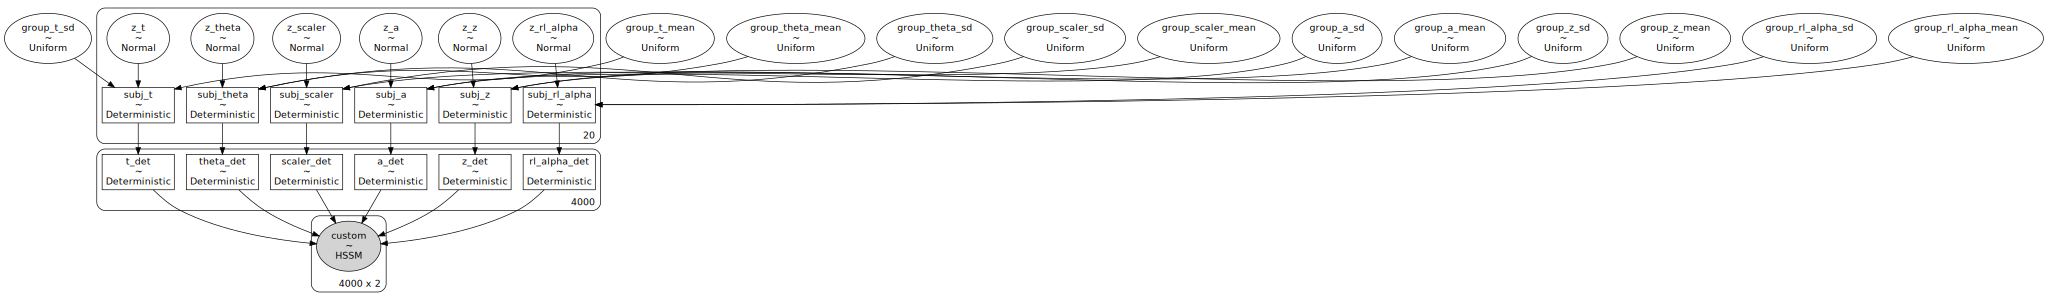

In [17]:
pm.model_to_graphviz(model)

In [18]:
with model:
    idata = pm.sample(draws=500, tune=500, chains=1, nuts_sampler="numpyro")

in Op:  False True [ 0  1  2 ... 17 18 19]
in Op:  False True [ 0  1  2 ... 17 18 19]
(4000, 11)
(4000, 11)


  0%|          | 0/1000 [00:00<?, ?it/s]

(4000, 11)


sample: 100%|██████████| 1000/1000 [09:28<00:00,  1.76it/s, 31 steps of size 1.23e-01. acc. prob=0.93]  
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
var_names_group_mean = [
    "group_rl_alpha_mean",
    "group_scaler_mean",
    "group_a_mean",
    "group_z_mean",
    "group_t_mean", 
    "group_theta_mean",
]

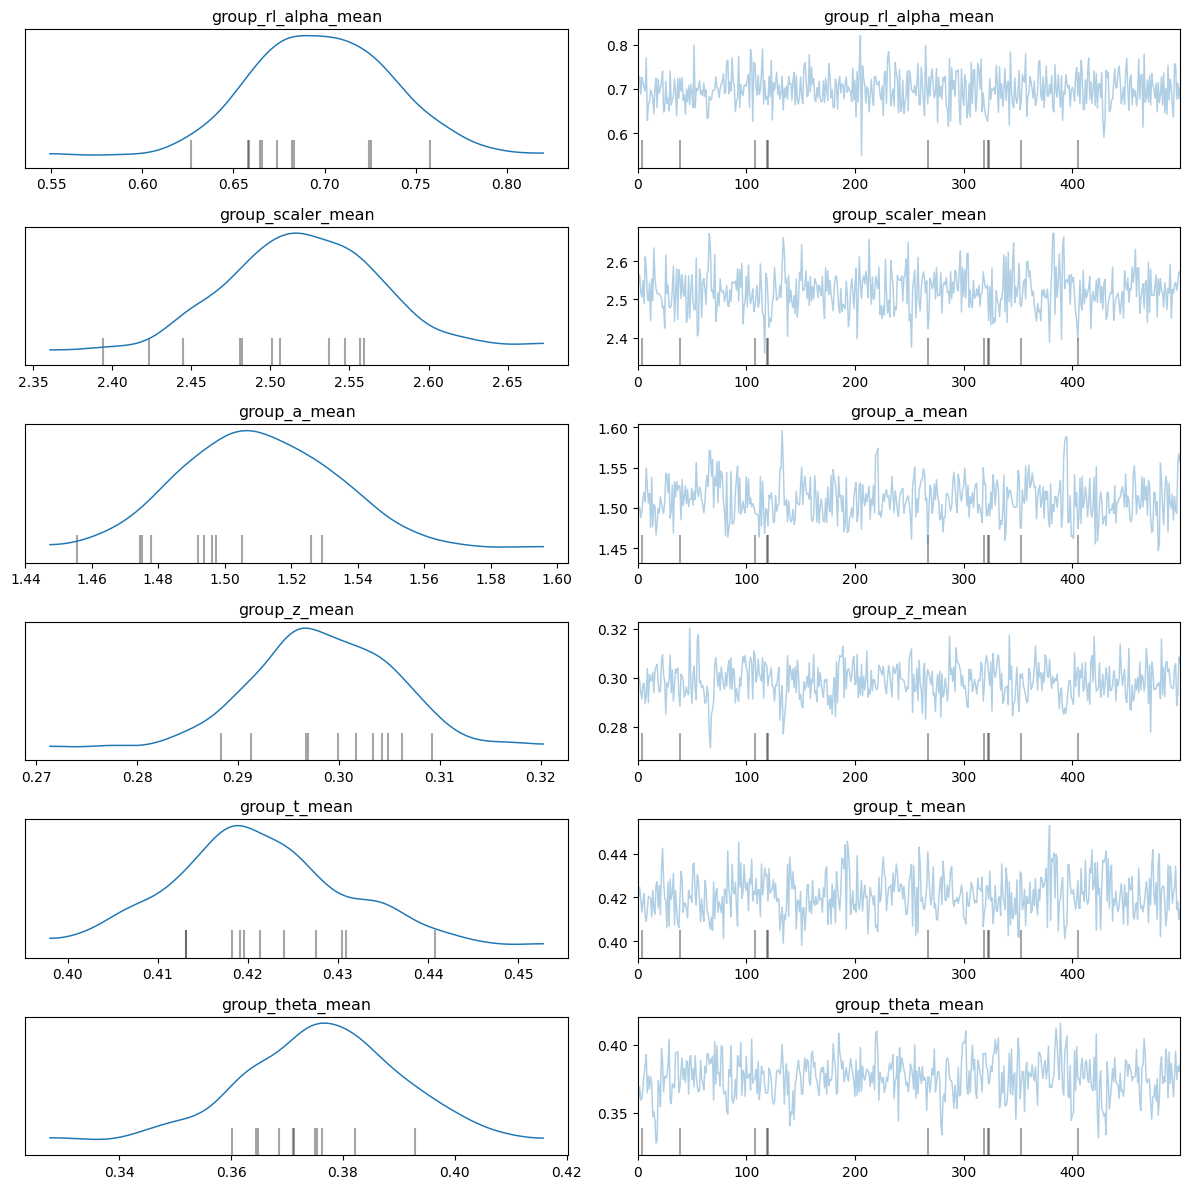

In [20]:
az.plot_trace(idata, var_names=var_names_group_mean)
plt.tight_layout()

In [ ]:
savefile['params_true_subj']['a']

In [23]:
az.summary(idata, var_names=var_names_group_mean)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_rl_alpha_mean,0.699,0.037,0.635,0.770,0.001,0.002,716.0,394.0,NaN
group_scaler_mean,2.522,0.050,2.434,2.623,0.003,0.002,306.0,347.0,NaN
group_a_mean,1.511,0.024,1.464,1.552,0.001,0.001,274.0,227.0,NaN
group_z_mean,0.299,0.007,0.285,0.310,0.000,0.000,236.0,255.0,NaN
group_t_mean,0.421,0.009,0.405,0.438,0.001,0.000,259.0,214.0,NaN
group_theta_mean,0.376,0.014,0.348,0.402,0.001,0.001,242.0,159.0,NaN


In [22]:
savefile['params_true_group']

{'rl_alpha_mean': 0.6599748892148676,
 'rl_alpha_std': 0.03361741613298558,
 'scaler_mean': 2.784958224189237,
 'scaler_std': 0.11254334695285723,
 'a_mean': 1.4813726831343665,
 'a_std': 0.06833257048261644,
 'z_mean': 0.2669095905671848,
 'z_std': 0.029806013334481733,
 't_mean': 0.44266787531912977,
 't_std': 0.014493710805742526,
 'theta_mean': 0.31170111158943425,
 'theta_std': 0.03531698660560417}

In [24]:
log_alpha_trace = idata.posterior["subj_rl_alpha"]
alpha_trace = np.exp(log_alpha_trace)
idata.posterior["subj_rl_alpha_orig"] = alpha_trace

In [25]:
param_names = [
    "subj_rl_alpha",
    "subj_scaler",
    "subj_a",
    "subj_z",
    "subj_t",
    "subj_theta",
]

In [26]:
def get_plot_data(posterior_idata, param_names, hdi_prob=0.85):
    plot_data = {}
    for p_name in param_names:
        if p_name == 'subj_alpha':
            access_p_name = 'subj_alpha_orig'
        else:
            access_p_name = p_name
        az_summary = az.summary(posterior_idata, var_names=[access_p_name], hdi_prob=hdi_prob, kind='stats', round_to=6)
        plot_data[p_name] = az_summary.values

        # get hdi columns in terms of the +/- range of mean (instead of the absolute values)
        plot_data[p_name][:, 2] = np.abs(plot_data[p_name][:, 2] - plot_data[p_name][:, 0])
        plot_data[p_name][:, 3] = np.abs(plot_data[p_name][:, 3] - plot_data[p_name][:, 0])
    
    return plot_data

In [27]:
plot_data = get_plot_data(idata, param_names)

In [28]:
sim_param_list = np.zeros((20, 6))

for ind, p in enumerate(savefile['params_true_subj'].keys()):
    sim_param_list[:, ind] = savefile['params_true_subj'][p]

In [29]:
param_names_latex = ['rl_alpha', 'scaler', 'a', 'z', 't', 'theta']
axes_lims = [[0.5, 0.9], [2.2, 3.5], [1.2, 2], [0, 0.4], [0.3, 0.7], [0.2, 0.5]]

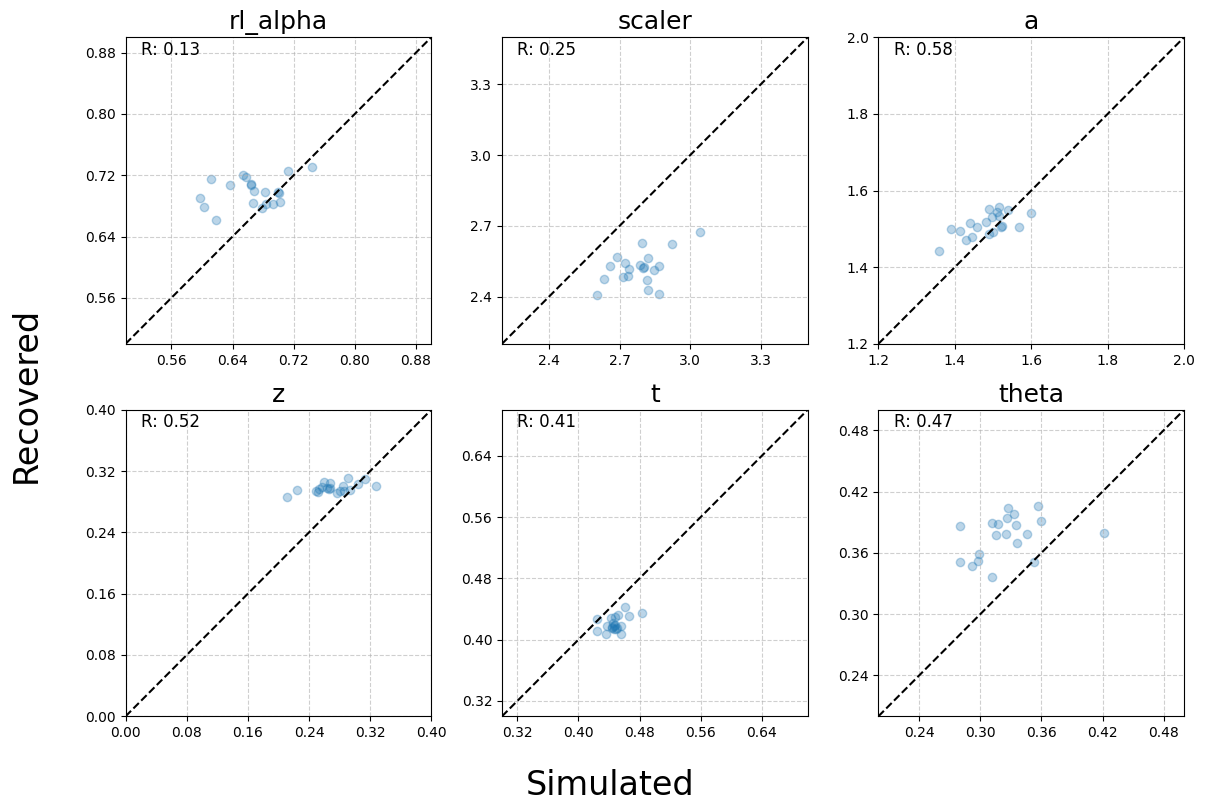

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(param_names):
        ax.set_visible(False)
        continue

    x = sim_param_list[:, i]
    y = plot_data[param_names[i]][:, 0]

    # Scatter plot 
    ax.scatter(x, y, alpha=0.3)

    # Calculate Spearman's R
    spearman_r, _ = spearmanr(x, y)

    # Add Spearman's R to the plot
    ax.text(0.05, 0.93, f"R: {spearman_r:.2f}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='bottom')

    # Customize subplot
    ax.set_title(param_names_latex[i], fontsize=18)
    ax.set_xlim(axes_lims[i])
    ax.set_ylim(axes_lims[i])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axline((0, 0), linestyle='--', slope=1, c='k')


fig.text(0.5, 0.00, 'Simulated', ha='center', fontsize=24)
fig.text(0.00, 0.5, 'Recovered', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()